# Fuzzy Name Matching
## Modeling

### This notebook analyzes the fuzzy name matching data using the following models.
1. XGBoost Classifier
2. Decision Tree Classifier
3. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

C:\Users\mkars\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Interim Data File Locations
interim_data = '../data/interim/'

In [3]:
df = pd.read_csv(interim_data + 'feature_engineering_results.csv')
df.shape

C:\Users\mkars\AppData\Local\Temp\ipykernel_21080\2650464768.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(interim_data + 'feature_engineering_results.csv')


(97108, 57)

In [4]:
df[df.confidential==0].sample(10)

,key,list_first_name,list_last_name,txn_first_name,txn_last_name,is_match,confidential,syll_list_first,syll_txn_first,syll_list_last,...,sift4_first,sift4_last,eudex_first,eudex_last,aline_first,aline_last,phoneticeditdistance_first,phoneticeditdistance_last,hmni_first,hmni_last
63616,1525,bekse,stratton,becse,stratton,1,0,"['be', 'kse']","['be', 'cse']","['strat', 'ton']",...,0.800000,1.000000,0.996078,1.000000,0.888889,1.000000,0.993548,1.000000,0.963627,1.000000
94413,32326,sergey,mohammad,mehitable,jesse,0,0,"['ser', 'gey']","['me', 'hi', 'ta', 'ble']","['mo', 'ham', 'mad']",...,0.222222,0.000000,0.720588,0.924510,0.240426,0.177273,0.568100,0.502016,0.000000,0.000000
75637,13548,prudence,dacus,puss,dacus,1,0,"['pru', 'den', 'ce']",['puss'],"['da', 'cus']",...,0.250000,1.000000,0.866667,1.000000,0.295455,1.000000,0.467742,1.000000,0.655946,1.000000
63215,1124,arabelle,crabtree,belle,crabtree,1,0,"['a', 'ra', 'bel', 'le']","['bel', 'le']","['crab', 'tree']",...,0.625000,1.000000,0.819608,1.000000,0.675000,1.000000,0.625000,1.000000,0.987531,1.000000
82505,20416,clayton,thao,hepsabah,fansler,0,0,"['clay', 'ton']","['he', 'psa', 'bah']",['thao'],...,0.125000,0.142857,0.849510,0.781863,0.320455,0.126829,0.655242,0.463134,0.000000,0.000000
95582,33495,tiljan,stoneburner,lenochka,waring,0,0,"['til', 'jan']","['le', 'noch', 'ka']","['sto', 'ne', 'bur', 'ner']",...,0.250000,0.090909,0.626471,0.710784,0.318182,0.237705,0.596774,0.476540,0.062584,0.045585
71870,9780,maggie,ridings,grethe,ridings,1,0,"['mag', 'gie']","['gret', 'he']","['ri', 'dings']",...,0.333333,1.000000,0.840686,1.000000,0.329412,1.000000,0.688172,1.000000,0.000000,1.000000
71407,9317,lotte,kugler,sherre,kugler,1,0,"['lot', 'te']","['sher', 're']","['ku', 'gler']",...,0.166667,1.000000,0.740196,1.000000,0.205882,1.000000,0.768817,1.000000,0.000000,1.000000
96070,33983,valeria,kron,nemo,viviano,0,0,"['va', 'le', 'ria']","['ne', 'mo']",['kron'],...,0.142857,0.142857,0.799510,0.785294,0.096970,0.281818,0.506912,0.481567,0.000000,0.024372
90350,28262,maty,iorio,nelis,ristau,0,0,"['ma', 'ty']","['ne', 'lis']","['io', 'rio']",...,0.000000,0.166667,0.928922,0.735784,0.325926,0.350000,0.709677,0.706989,0.000000,0.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97108 entries, 0 to 97107
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   key                          97108 non-null  object 
 1   list_first_name              97083 non-null  object 
 2   list_last_name               97100 non-null  object 
 3   txn_first_name               97089 non-null  object 
 4   txn_last_name                97101 non-null  object 
 5   is_match                     97108 non-null  int64  
 6   confidential                 97108 non-null  int64  
 7   syll_list_first              97108 non-null  object 
 8   syll_txn_first               97108 non-null  object 
 9   syll_list_last               97108 non-null  object 
 10  syll_txn_last                97108 non-null  object 
 11  partial_first                97108 non-null  int64  
 12  partial_last                 97108 non-null  int64  
 13  tkn_sort_first  

## Select Features for Engineering

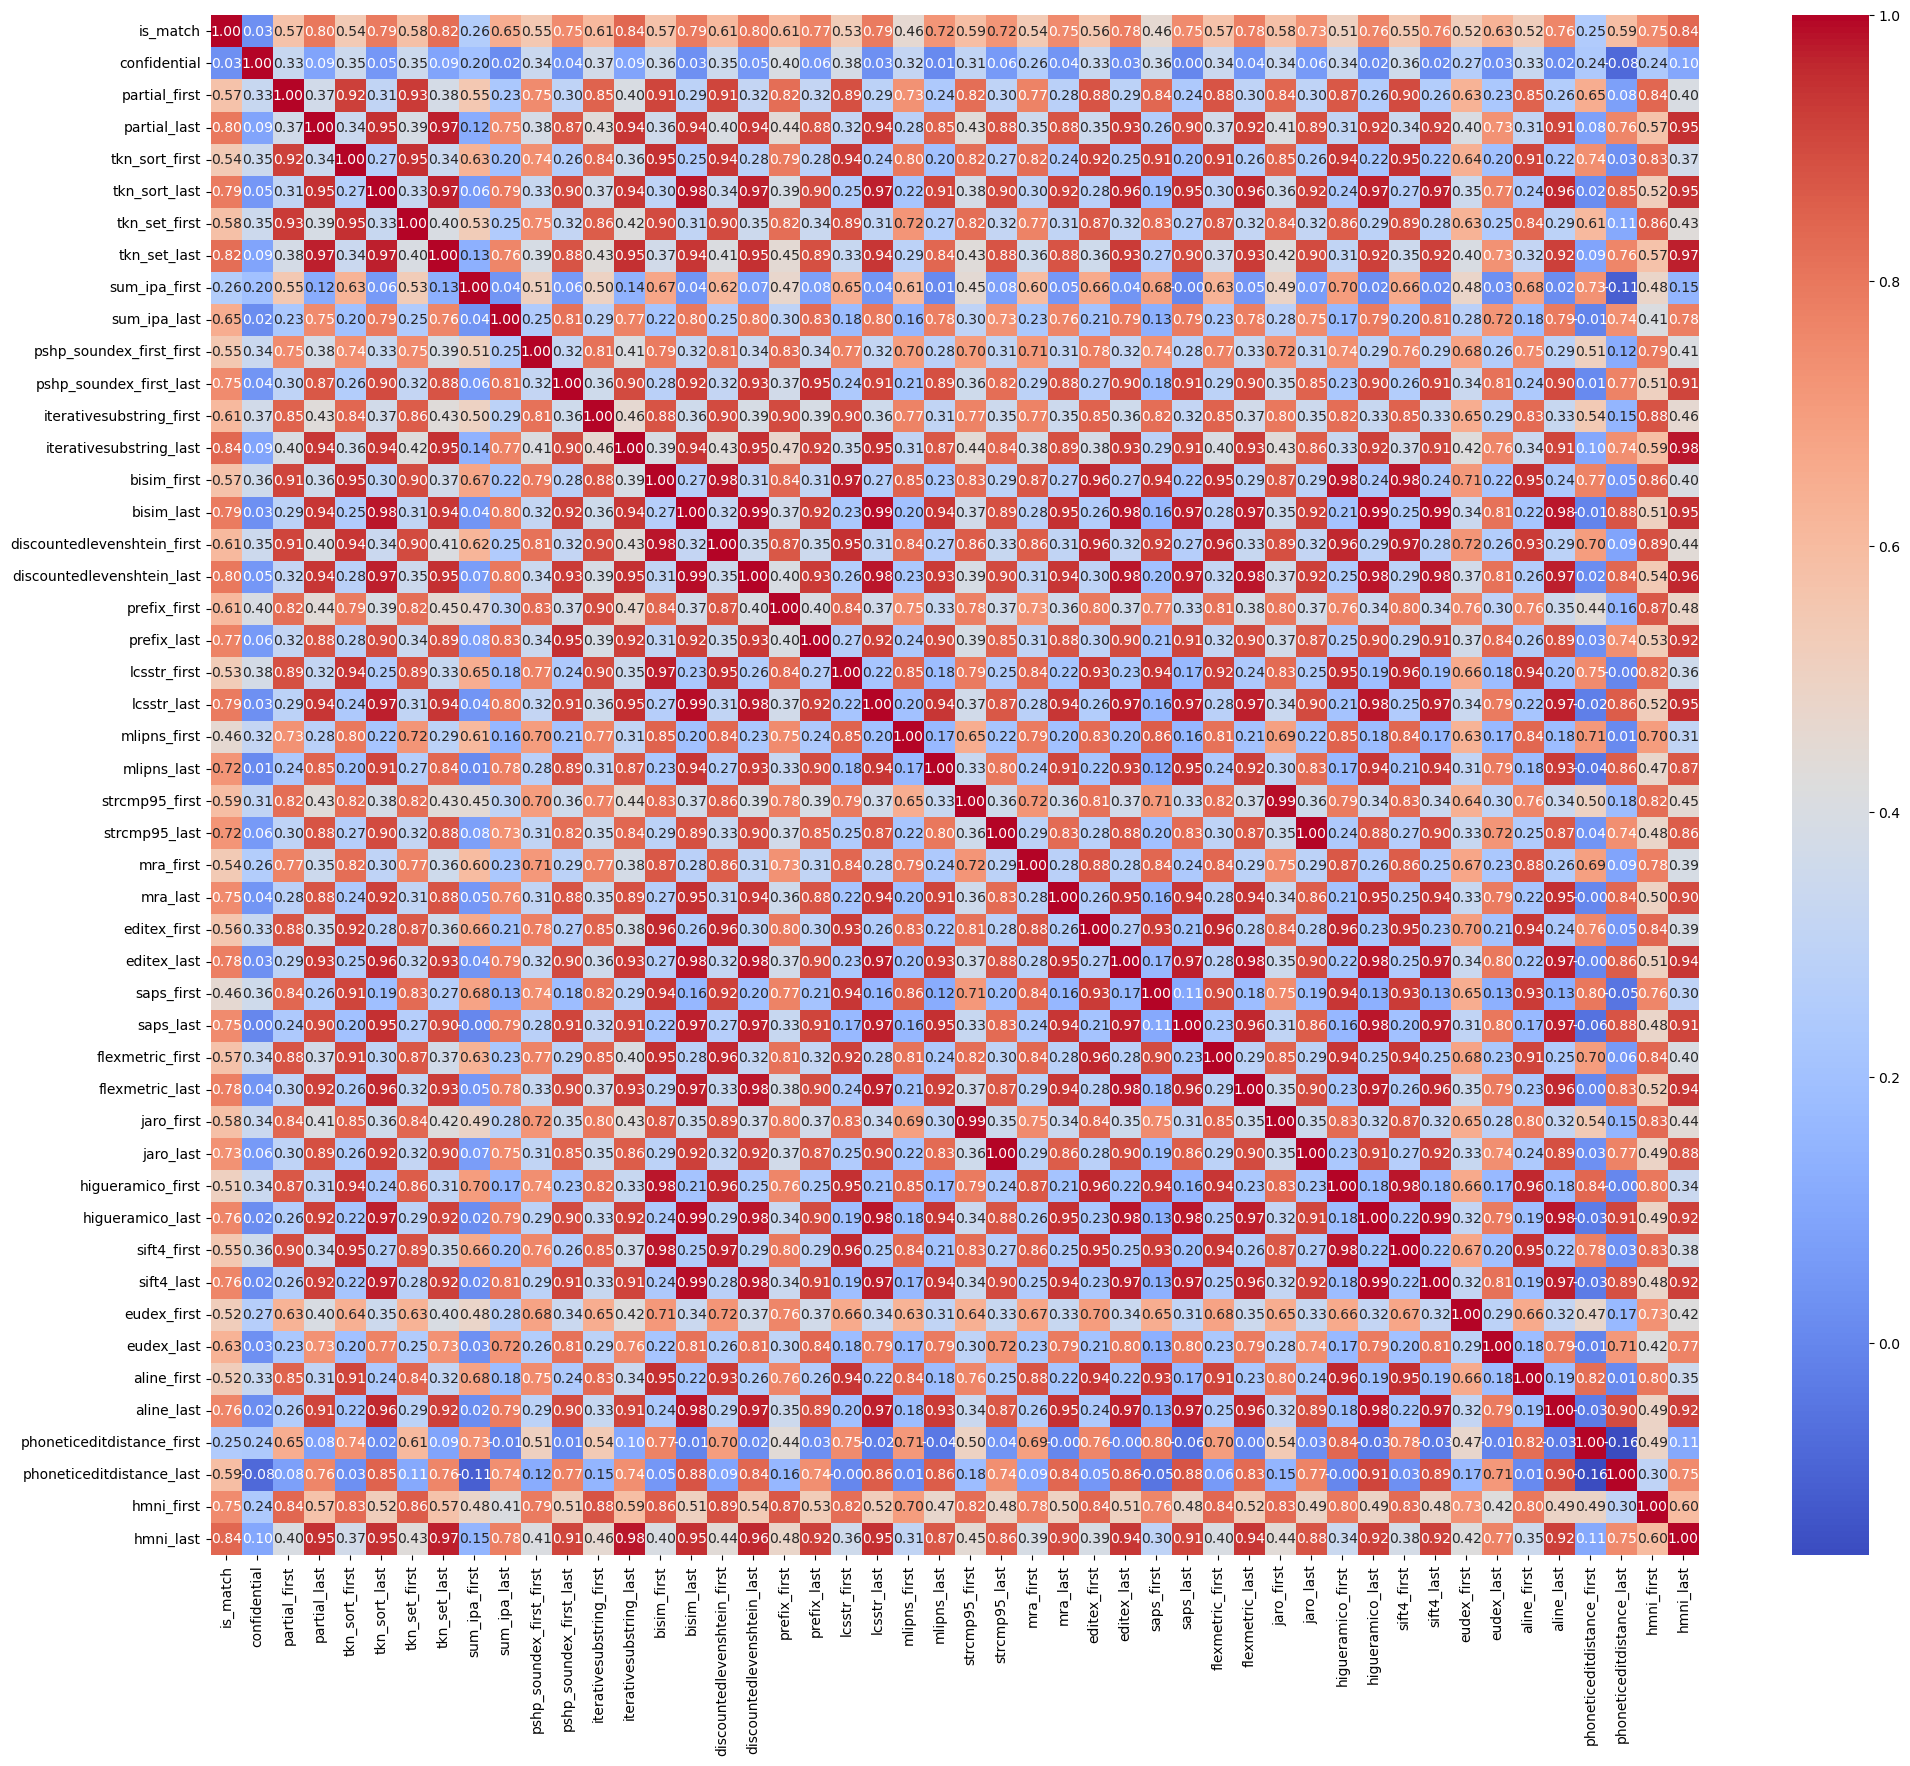

In [6]:
corr = df.corr()
plt.subplots(figsize=(24,20))
sns.heatmap(round(corr, 2), annot=True, fmt='.2f', cmap="coolwarm");

In [7]:
# Extract target dependent variable to y
y = df.is_match

In [8]:
# Extract independent feature variables to X
drop_cols = ['is_match', 'key', 'list_first_name', 'list_last_name', 'txn_first_name', 'txn_last_name', 
             'confidential', 'syll_list_first', 'syll_txn_first', 'syll_list_last', 'syll_txn_last']
X = df.drop(columns=drop_cols, axis=1)

In [9]:
X.head()

,partial_first,partial_last,tkn_sort_first,tkn_sort_last,tkn_set_first,tkn_set_last,sum_ipa_first,sum_ipa_last,pshp_soundex_first_first,pshp_soundex_first_last,...,sift4_first,sift4_last,eudex_first,eudex_last,aline_first,aline_last,phoneticeditdistance_first,phoneticeditdistance_last,hmni_first,hmni_last
0,92,100,92,100,92,100,1.000000,1.000000,1,1,...,0.833333,1.000000,0.980392,1.00000,0.764706,1.000000,0.833333,1.000000,0.921601,1.000000
1,83,100,73,100,73,100,0.967742,1.000000,1,1,...,0.600000,1.000000,1.000000,1.00000,0.891304,1.000000,0.793548,1.000000,0.966138,1.000000
2,75,100,62,100,62,100,0.940860,1.000000,1,1,...,0.428571,1.000000,0.987255,1.00000,0.432432,1.000000,0.566820,1.000000,0.901628,1.000000
3,100,85,100,86,100,86,1.000000,0.994624,1,1,...,1.000000,0.714286,1.000000,0.97598,1.000000,0.658537,1.000000,0.714286,1.000000,0.981494
4,95,100,90,100,90,100,0.704301,1.000000,1,1,...,0.875000,1.000000,0.988235,1.00000,0.725000,1.000000,0.967742,1.000000,0.949048,1.000000


In [10]:
# Call train_test_split on X, y. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(77686, 46) (77686,)
(19422, 46) (19422,)


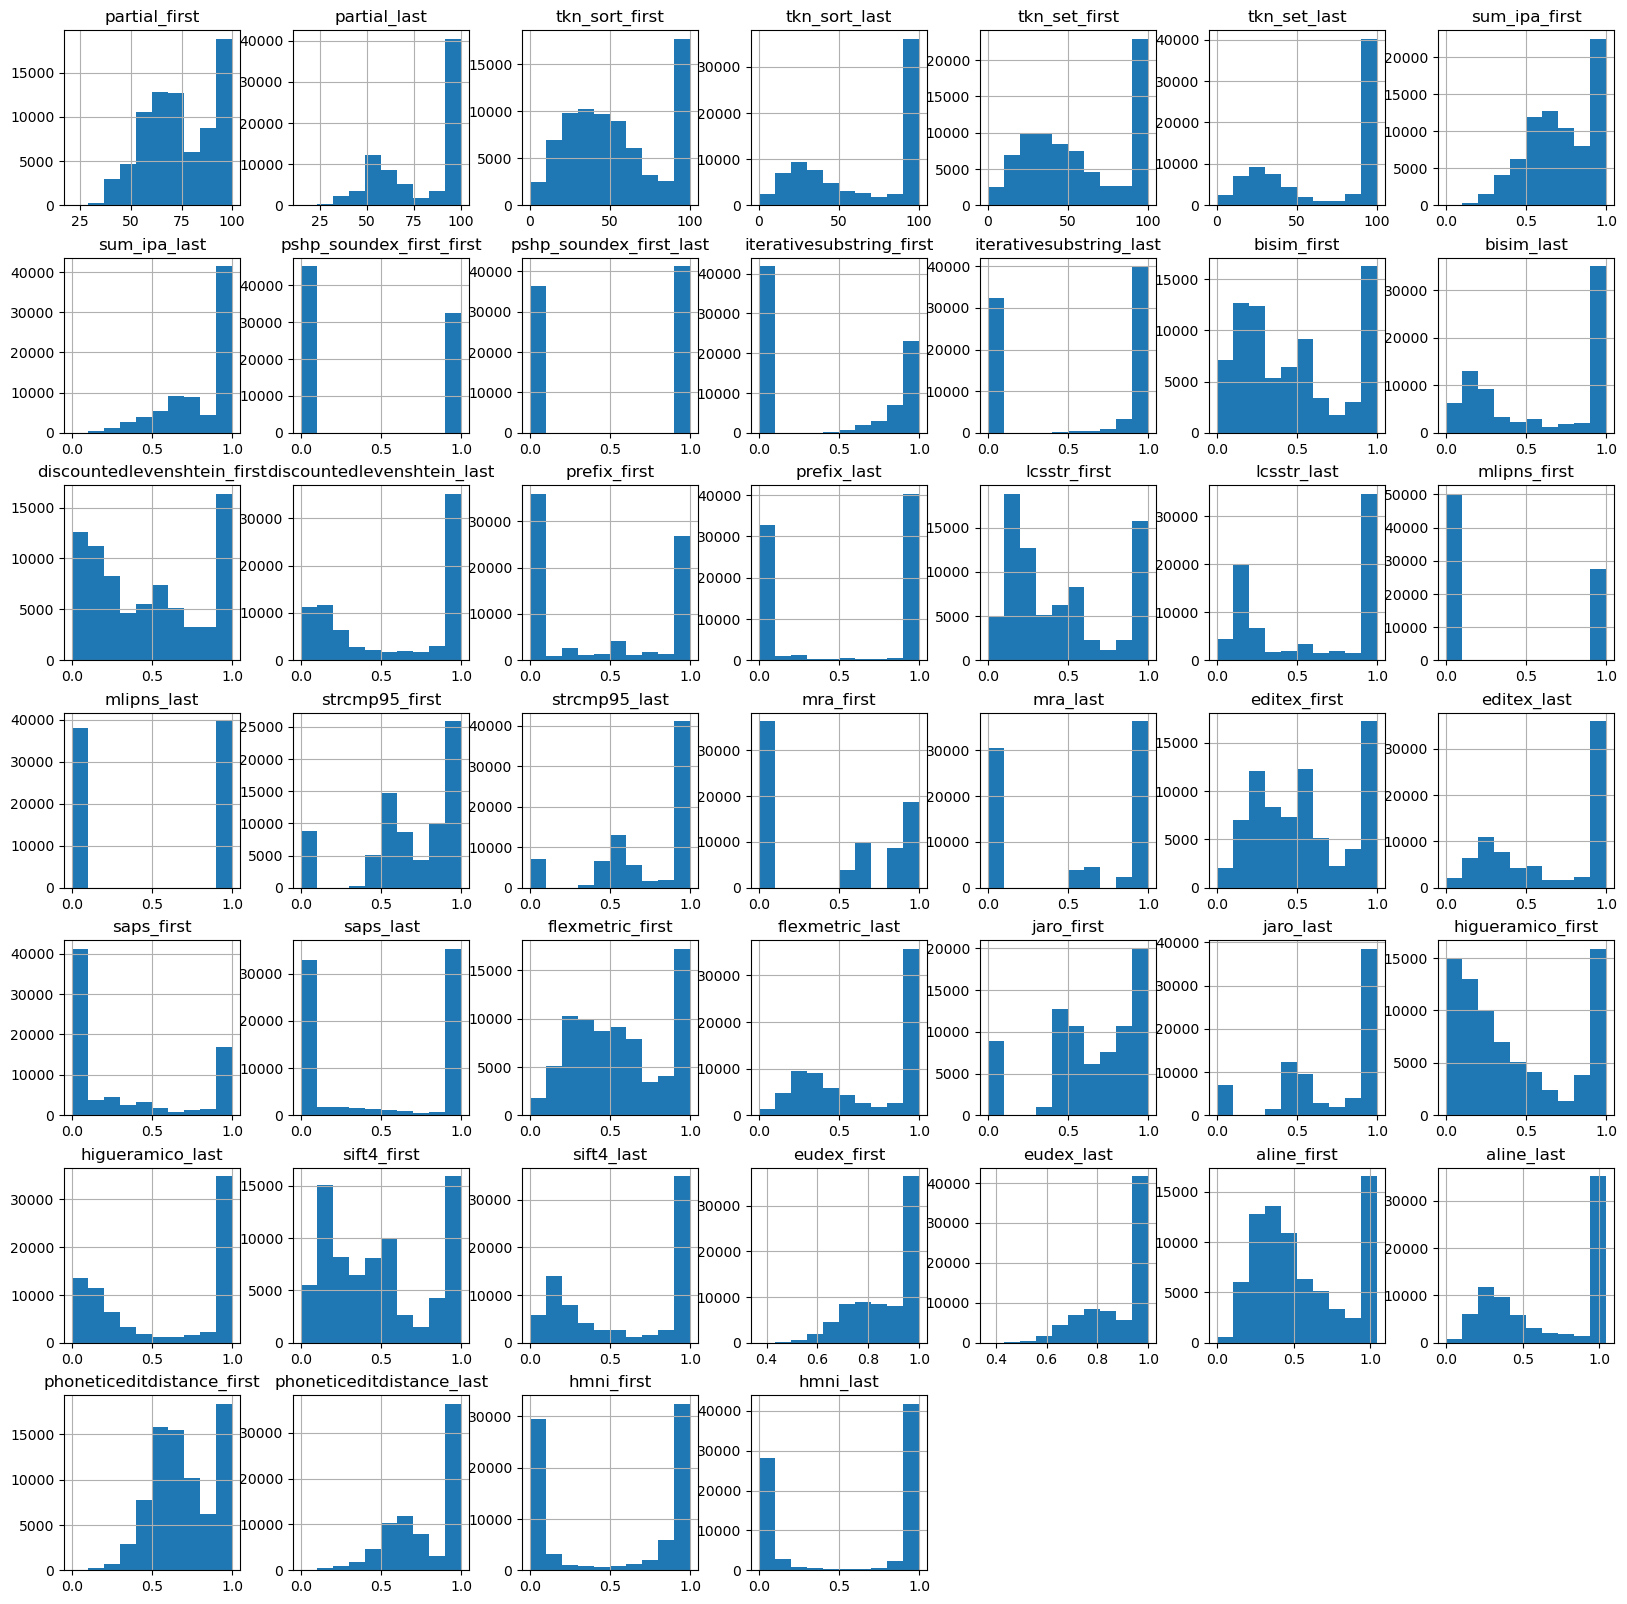

In [11]:
X_train.hist(figsize=(20, 20))
plt.show()

## Scale Features

In [12]:
# Apply a standard scaler to the training and test data
SS_scaler = StandardScaler()
X_train_scaled = SS_scaler.fit_transform(X_train)
X_test_scaled = SS_scaler.transform(X_test)

## Model Tuning & Evaluation

In [13]:
def model_tune(model_id, model, param_dist):
    # Instantiate the RandomizedSearchCV object: model_cv
    model_cv = RandomizedSearchCV(model, param_dist, cv=5)

    # Fit it to the data
    model_cv.fit(X_train, y_train.values.ravel())

    # Print the tuned parameters and score
    print("Model: {}".format(model_id))
    print("Tuned Hyper Parameters: {}".format(model_cv.best_params_))
    print("Best score is {}".format(model_cv.best_score_))
    
    # Fit model with optimal hyper parameters
    model.set_params(**model_cv.best_params_)
    model.fit(X_train, y_train.values.ravel())
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    print(f"Train Score: {score_train}")
    print(f"Test Score: {score_test}")
    
    # Calculate Accuracy Score
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print("Accuracy Score:", score)

    df_plot_res = y_test.copy()
    df_plot_res['predicted_match'] = y_pred
    
    # Plot Results
    fig, ax = plt.subplots(figsize=(20, 10))   
    plt.plot(range(df_plot_res.shape[0]), 'is_match', data=df_plot_res.sort_values('is_match'), label='actual', color='b')
    plt.scatter(range(df_plot_res.shape[0]), 'predicted_match', data=df_plot_res.sort_values('is_match'), 
                label='predicted', color='r', alpha=0.5)
    plt.xlabel('Count')
    plt.ylabel('Match')
    plt.legend()
    plt.title('Sales Price - Actual vs. Predicted')
    plt.show()

    # Append results to DataFrame
    res = pd.DataFrame([[model_id, model_cv.best_params_, score_train, score_test, score]], 
                      columns=['Model', 'Parms', 'Score_Train', 'Score_Test', 'Accuracy_Score'])
    return res, y_pred

### XGBoost Classifier

In [15]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
param_dist = {
            'n_estimators': [10, 50, 100, 500, 1000],
            'max_depth': [2, 3, 5, 10, 15],
            'learning_rate': [0.05, 0.1, 0.15, 0.20],
            'min_child_weight': [1, 2, 3, 4]
            }
res, y_pred_xgb = model_tune('XGB', xgb, param_dist)
res_df = pd.concat([res_df, res])
res_df.head()

C:\Users\mkars\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


KeyboardInterrupt: 

In [ ]:
xgb.feature_importances_

In [ ]:
xgb_feat_imp = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: -x[1])
xgb_feat_imp = pd.DataFrame(xgb_feat_imp)
xgb_feat_imp.columns=["Feature", "Weight"]
xgb_feat_imp.head(20)

In [ ]:
plt.subplots(figsize=(10, 5))
sns.barplot(y="Feature", x="Weight", data=xgb_feat_imp, orient = 'h')
plt.xlabel('Weight')
plt.ylabel('Feature')
# plt.xticks(rotation = 90)
plt.title('Feature Importance')
sns.despine()
plt.show()